### Multiround UNL Attack Mixed

Figure 5abc, and 6c
Adjust the aggregation method accordingly based on hyperparameters (trimmed mean cutoff) to replicate results

Can also use this code to perform experiments for table 2

##### Summary
Load FAT model trained for 150 rounds and for 50 rounds try and inject FedAvg model into the system. Try different scaling rates and spread out the model replacement attack.

In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
# Specify aggregation method, number of clients, and dataset
setting, num_user = "FedAvg_adv", 40
exp = "cifar10"

# Load models for FAT and FedAvg - write down path to where weights are saved
save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/cifar10/250123_icml25/FAT/'
save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/cifar10/250123_icml25/FedAvg/'
# save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FAT_ep02/'
# save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FedAvg/'

# Attack parameters for performing PGD 
eps_attack = 4.0
eps_train = 4.5
step_size = 0.01
steps = 10

In [4]:
# Generate instance of aggregator that holds all clients, data and models and load relevant models in
try: # Skip loading if already loaded
    aggregator_og
except:
    aggregator_og, clients, args_ = set_args(setting, num_user,  experiment = exp) # Indicate dataset here

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator_og, args_)[0])
model_Fedavg = copy.deepcopy(import_model_weights(num_user, setting, save_path_FedAvg, aggregator_og, args_)[0])

# Obtain parameters for each layer
params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Just take the values of weights and bias for the model
desired_keys = params_FAT.keys() # [key for key in params_FAT.keys() if 'weight' in key or 'bias' in key] # 

==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 68.76it/s] 


===> Initializing clients..


  0%|          | 0/40 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 40/40 [00:25<00:00,  1.57it/s]
/home/ubuntu/fedatk_unl_tj/aggregator.py:289: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious p

In [5]:
num_aru = [5, 5, 10, 10]
beta_params = [0.05, 0.1, 0.1, 0.2]
weight2_list = [0.3, 0.2, 0.3, 0.2]
agg_options = ["median_sublayers", "median_sublayers", "median_sublayers","median_sublayers"]

median_layers = ['features.1.', 'features.2.', 'features.4.', 'features.14.', 'features.17.'] # period is important 

num_rounds = 20
eps = eps_attack

result_list = []
for itt in range(len(num_aru)):
    result_list += [{}]

# setting, num_user = "FedAvg_adv", 20
save_path_FedAvg_150R = save_path_FAT# '/home/ubuntu/fedatk_unl_tj/weights/cifar10/250123_icml25/FAT_R50/'
aggregator, clients, args_ = set_args(setting, num_user,  experiment = exp)

agg_choice = random.choices(range(3),k=num_rounds)

if True:
    print("updating adv data set")
    # add adv dataset update
    Fu = np.zeros(num_user)
    Fu[0:40] = 0.5

    # Setting evasion attack parameters
    x_min = torch.min(clients[0].adv_nn.dataloader.x_data)
    x_max = torch.max(clients[0].adv_nn.dataloader.x_data)
    atk_params = PGD_Params()
    atk_params.set_params(batch_size=1, iteration = 10,
                    target = -1, x_val_min = x_min, x_val_max = x_max,
                    step_size = step_size, step_norm = "inf", eps = eps, eps_norm = 2)

    # Assign proportion and attack params
    for c in range(len(clients)):
        if Fu[c] > 0:
            aggregator.clients[c].set_adv_params(Fu[c], atk_params)
            aggregator.clients[c].update_advnn()
            aggregator.clients[c].assign_advdataset()

for itt in range(len(beta_params)):
    # Perform 50 rounds of FAT on FedAvg model 
    num_adv = num_aru[itt]
    weight2 = 1/num_adv * weight2_list[itt]
    adv_id = random.sample(range(20,num_user), num_adv) # excluding 0-9 as Fu = 1
    beta = beta_params[itt]

    test_acc_gather = []
    adv_acc_gather = []
    test_acc_std = []
    adv_acc_std = []
    cosine_gather_layers = np.zeros([num_rounds, len(desired_keys)])

    aggregator.tm_rate = beta

    # Test performance of aggregator on data 
    aggregator.load_state(dir_path = save_path_FedAvg_150R)
    aggregator.update_clients()
    model_FA = pull_model_from_agg(aggregator)
    model_FA.eval()
    acc, adv_acc = get_adv_acc(aggregator, model_FA, eps = eps)

    # prev_model = copy.deepcopy(model_FA)

    print("Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))
    test_acc_gather+= [np.mean(acc)]
    adv_acc_gather += [np.mean(adv_acc)]
    test_acc_std += [np.std(acc)]
    adv_acc_std += [np.std(adv_acc)]



    for i in range(num_rounds):

        # Per round Freq
        aggregator.aggregation_op = agg_options[itt]

        # aggregator.mix()
        UNL_mix_novel(aggregator, adv_id, model_inject = model_Fedavg, keys = desired_keys, weight_scale_2 = weight2, dump_flag=False, tm_beta=beta, median_layers = median_layers)
        model_overfit = pull_model_from_agg(aggregator)
        model_overfit.eval()
        acc, adv_acc = get_adv_acc(aggregator, model_overfit, eps = eps)

        print("round", i,"Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))
        test_acc_gather+= [np.mean(acc)]
        adv_acc_gather += [np.mean(adv_acc)]
        test_acc_std += [np.std(acc)]
        adv_acc_std += [np.std(adv_acc)]
        # prev_model = copy.deepcopy(model_overfit)

        result_list[itt]['test_acc'] = copy.deepcopy(test_acc_gather)
        result_list[itt]['adv_acc'] = copy.deepcopy(adv_acc_gather)
        result_list[itt]['test_std'] = copy.deepcopy(test_acc_std)
        result_list[itt]['adv_std'] = copy.deepcopy(adv_acc_std)
        result_list[itt]['num_clients'] = num_adv
        result_list[itt]['beta'] = beta
        result_list[itt]['weight2'] = weight2_list[itt]
        # Perform gradient direction gathering

        del model_overfit
        gc.collect()
        torch.cuda.empty_cache()


    

==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 108.73it/s]


===> Initializing clients..


100%|██████████| 40/40 [00:24<00:00,  1.64it/s]


updating adv data set
Test acc:  0.8062500014901162 adv acc:  0.41500000171363355


/home/ubuntu/fedatk_unl_tj/learners/learner.py:192: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  loss = (loss_vec.T @ weights[indices]) / loss_vec.size(0)


Successfully copied values of 'features.17.conv.1.1.running_var' from source_model to target_model.
Values of 'features.17.conv.1.1.running_var' successfully updated in the new model.
round 0 Test acc:  0.8181249991059303 adv acc:  0.37406250089406967
Successfully copied values of 'features.17.conv.1.1.running_var' from source_model to target_model.
Values of 'features.17.conv.1.1.running_var' successfully updated in the new model.
round 1 Test acc:  0.8162499979138375 adv acc:  0.3171875014901161
Successfully copied values of 'features.17.conv.1.1.running_var' from source_model to target_model.
Values of 'features.17.conv.1.1.running_var' successfully updated in the new model.
round 2 Test acc:  0.803437502682209 adv acc:  0.26781249828636644
Successfully copied values of 'features.17.conv.1.1.running_var' from source_model to target_model.
Values of 'features.17.conv.1.1.running_var' successfully updated in the new model.
round 3 Test acc:  0.8046875014901161 adv acc:  0.232187499105

KeyboardInterrupt: 

In [10]:
import pickle

a = result_list

with open('saved_results/mixed_sweep/250128_5b_msub_arui_1241417.pk', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
with open('saved_results/mixed_sweep/250128_5b_msub_arui_1241417.pk', 'rb') as handle:
    result_list = pickle.load(handle)

num_rounds = 20

[5, 0.05, 0.3]
acc
0.7959375023841858
std
0.04663584975457277
advacc
0.07781250041443855
std
0.0314353873788894
[5, 0.1, 0.2]
acc
0.8065624967217445
std
0.04643438340383434
advacc
0.22468749880790712
std
0.05607524957908537
[10, 0.1, 0.3]
acc
0.7834374964237213
std
0.05350142362212567
advacc
0.08125000065192581
std
0.028504384929094052
[10, 0.2, 0.2]
acc
0.8040624976158142
std
0.05202069032184
advacc
0.23718749843537806
std
0.04467657003657428


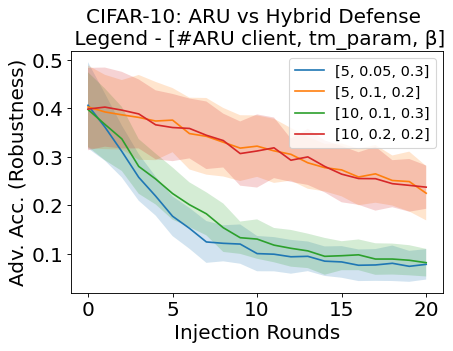

In [7]:
import matplotlib.pyplot as plt
import numpy as np

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.figure(dpi=80, figsize=(6,4))

plot_settings = [[5 ,0.05,0.3],[5 ,0.1, 0.2],[10, 0.1, 0.3], [10, 0.2, 0.2]]

# Generate some sample data
x = range(num_rounds+1)  # 100 points from 0 to 10

# Plotting the lines
# plt.plot(x, y1, label='Test Acc')
label_list = plot_settings
for i in range(len(label_list)):
    y = np.array(result_list[i]['adv_acc'])
    error = np.array(result_list[i]['adv_std'])
    plt.plot(x, y, label= str(label_list[i]))
    plt.fill_between(x, y-error, y+error,
    alpha=0.2)

    print(plot_settings[i])

    print('acc')
    print(result_list[i]['test_acc'][-1])
    print('std')
    print(result_list[i]['test_std'][-1])

    print('advacc')
    print(result_list[i]['adv_acc'][-1])
    print('std')
    print(result_list[i]['adv_std'][-1])

# Adding labels and title
plt.xlabel('Injection Rounds')
plt.ylabel('Adv. Acc. (Robustness)')
plt.title('CIFAR-10: ARU vs Hybrid Defense \n Legend - [#ARU client, tm_param, β]', fontsize = 'medium')

# Adding a legend
plt.legend( loc="best", fontsize=13)


# Display the plot
plt.show()
